# Importing some packages

In [2]:
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from scipy.stats import iqr
from statsmodels.tsa.deterministic import CalendarFourier

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

from xgboost import XGBRegressor

# Loading data

In [3]:
train_df = pd.read_excel('Train.xlsx')
test_df = pd.read_excel('Test.xlsx')
sub_df = pd.read_csv('Submission.csv')

# Splitting data

First of all let's extract some features from datetime to facilitate future calculations: otherwise I will be forced to extract the same features for each split of the data.

In [4]:
train_df['dayofweek'] = train_df['Datetime'].apply(lambda x: x.dayofweek)
train_df['weekofyear'] = train_df['Datetime'].apply(lambda x: x.isocalendar()[1])
# train_df['weekofyear'] = train_df['weekofyear'].apply(int)
train_df['dayofyear'] = train_df['Datetime'].dt.dayofyear

test_df['dayofweek'] = test_df['Datetime'].apply(lambda x: x.dayofweek)
test_df['weekofyear'] = test_df['Datetime'].apply(lambda x: x.isocalendar()[1])
# test_df['weekofyear'] = test_df['weekofyear'].apply(int)
test_df['dayofyear'] = test_df['Datetime'].dt.dayofyear

Let's find missing dates in the train data: the code comes from eda.ipynb notebook, but is self-explanatory too.

In [5]:
train_full_dates = pd.date_range(start='2013-01-01', end='2016-06-01', freq='60min')[:-1]

missing_dates_dict = {}
for user_type in train_df['User_type'].unique():
    train_date = train_df[train_df['User_type']==user_type]['Datetime'].tolist()
    missing_dates = [i for i in train_full_dates if i not in train_date]
    missing_dates_dict[user_type] = missing_dates
    print(f"{user_type}: {len(missing_dates)} missing dates")

occasional: 97 missing dates
subscribed: 50 missing dates


Let's separate train and test data by user type as there will be a model for each user type.

In [6]:
train_df.drop(columns='Unnamed: 0', inplace=True)

train_df_s = train_df[train_df['User_type']=='subscribed'].reset_index(drop=True)
train_df_s.sort_values('Datetime', ascending=True, inplace=True)
train_df_o = train_df[train_df['User_type']=='occasional'].reset_index(drop=True)
train_df_o.sort_values('Datetime', ascending=True, inplace=True)

print(train_df_s.shape, train_df_o.shape)

(29878, 10) (29831, 10)


In [7]:
test_df.rename(
    columns={'Unnamed: 0': 'index'},
    inplace=True
)

test_df_s = test_df[test_df['User_type']=='subscribed'].reset_index(drop=True)
test_df_s.sort_values('Datetime', ascending=True, inplace=True)
test_df_o = test_df[test_df['User_type']=='occasional'].reset_index(drop=True)
test_df_o.sort_values('Datetime', ascending=True, inplace=True)

print(test_df_s.shape, test_df_o.shape)

(720, 10) (720, 10)


Choosing last 720 (this is the length of the test set) values as a validation set for each split.

In [8]:
valid_df_s = train_df_s.iloc[-720:]
train_df_s = train_df_s.iloc[:-720]
print(valid_df_s.shape, train_df_s.shape)

(720, 10) (29158, 10)


In [9]:
valid_df_o = train_df_o.iloc[-720:]
train_df_o = train_df_o.iloc[:-720]
print(valid_df_o.shape, train_df_o.shape)

(720, 10) (29111, 10)


Filling missing dates and corresponding feature values

In [10]:
for user_type in train_df['User_type'].unique():

    if user_type == 'occasional':
        temp_train_df = train_df_o.copy()
    else:
        temp_train_df = train_df_s.copy()

    train_dict = defaultdict(list)
    valid_dict = defaultdict(list)

    for missing_date in missing_dates_dict[user_type]:

        if missing_date < valid_df_s.iloc[0]['Datetime']:
            train_dict['Datetime'].append(missing_date)
            train_dict['St_Hour'].append(missing_date.hour)
            train_dict['St_Day'].append(missing_date.day)
            train_dict['St_Month'].append(missing_date.month)
            train_dict['St_Year'].append(missing_date.year)
            train_dict['dayofweek'].append(missing_date.dayofweek)
            train_dict['weekofyear'].append(missing_date.isocalendar()[1])
            train_dict['dayofyear'].append(missing_date.dayofyear)
            train_dict['User_type'].append(user_type)
            temp_df = temp_train_df[
                (temp_train_df['Datetime']<missing_date) & 
                (temp_train_df['St_Hour']==missing_date.hour)
            ]
            train_dict['Rental_Bicycles_Count'] = temp_df['Rental_Bicycles_Count'].median()
        else:
            valid_dict['Datetime'].append(missing_date)
            valid_dict['St_Hour'].append(missing_date.hour)
            valid_dict['St_Day'].append(missing_date.day)
            valid_dict['St_Month'].append(missing_date.month)
            valid_dict['St_Year'].append(missing_date.year)
            valid_dict['dayofweek'].append(missing_date.dayofweek)
            valid_dict['weekofyear'].append(missing_date.isocalendar()[1])
            valid_dict['dayofyear'].append(missing_date.dayofyear)
            valid_dict['User_type'].append(user_type)
            valid_dict['Rental_Bicycles_Count'] = temp_train_df[temp_train_df['St_Hour']==missing_date.hour]['Rental_Bicycles_Count'].median()

    if user_type == 'occasional':
        temp_train_df_o = pd.DataFrame(train_dict)
        temp_train_df_o = temp_train_df_o[train_df_o.columns]
        train_df_o = pd.concat([train_df_o, temp_train_df_o], axis=0).reset_index(drop=True)
        train_df_o.sort_values('Datetime', ascending=True, inplace=True)

        if len(valid_dict) != 0:
            temp_valid_df_o = pd.DataFrame(valid_dict)
            temp_valid_df_o = temp_valid_df_o[valid_df_o.columns]
            valid_df_o = pd.concat([valid_df_o, temp_valid_df_o], axis=0).reset_index(drop=True)
            valid_df_o.sort_values('Datetime', ascending=True, inplace=True)
    else:
        temp_train_df_s = pd.DataFrame(train_dict)
        temp_train_df_s = temp_train_df_s[train_df_s.columns]
        train_df_s = pd.concat([train_df_s, temp_train_df_s], axis=0).reset_index(drop=True)
        train_df_s.sort_values('Datetime', ascending=True, inplace=True)

        if len(valid_dict) != 0:
            temp_valid_df_s = pd.DataFrame(valid_dict)
            temp_valid_df_s = temp_valid_df_s[valid_df_s.columns]
            valid_df_s = pd.concat([valid_df_s, temp_valid_df_s], axis=0).reset_index(drop=True)
            valid_df_s.sort_values('Datetime', ascending=True, inplace=True)

print(valid_df_s.shape, train_df_s.shape)
print(valid_df_o.shape, train_df_o.shape)

(720, 10) (29208, 10)
(720, 10) (29208, 10)


Checking the new datasets

In [11]:
train_df_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29208 entries, 0 to 29157
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   St_Hour                29208 non-null  int64         
 1   St_Day                 29208 non-null  int64         
 2   St_Month               29208 non-null  int64         
 3   St_Year                29208 non-null  int64         
 4   User_type              29208 non-null  object        
 5   Datetime               29208 non-null  datetime64[ns]
 6   Rental_Bicycles_Count  29208 non-null  float64       
 7   dayofweek              29208 non-null  int64         
 8   weekofyear             29208 non-null  int64         
 9   dayofyear              29208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 2.5+ MB


In [12]:
train_df_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29208 entries, 0 to 29110
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   St_Hour                29208 non-null  int64         
 1   St_Day                 29208 non-null  int64         
 2   St_Month               29208 non-null  int64         
 3   St_Year                29208 non-null  int64         
 4   User_type              29208 non-null  object        
 5   Datetime               29208 non-null  datetime64[ns]
 6   Rental_Bicycles_Count  29208 non-null  float64       
 7   dayofweek              29208 non-null  int64         
 8   weekofyear             29208 non-null  int64         
 9   dayofyear              29208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 2.5+ MB


# Feature Engineering

Let's create some dummy features which will take into account day of week, week of year, hour of day, and month.

In [13]:
encoder_s = OneHotEncoder(drop='first')

dummy_columns = ['St_Hour', 'St_Month', 'dayofweek', 'weekofyear']

train_array_s_dummies = encoder_s.fit_transform(
    train_df_s[dummy_columns]
).toarray()

train_s_columns = []

for i in range(len(encoder_s.categories_)):
    for j in encoder_s.categories_[i][1:]:
        train_s_columns.append(dummy_columns[i]+'_'+str(j))

train_df_s_dummies = pd.DataFrame(
    train_array_s_dummies,
    columns=train_s_columns
)

valid_array_s_dummies = encoder_s.transform(
    valid_df_s[dummy_columns]
).toarray()

valid_df_s_dummies = pd.DataFrame(
    valid_array_s_dummies,
    columns=train_s_columns
)

test_array_s_dummies = encoder_s.transform(
    test_df_s[dummy_columns]
).toarray()

test_df_s_dummies = pd.DataFrame(
    test_array_s_dummies,
    columns=train_s_columns
)

print(valid_df_s_dummies.shape, train_df_s_dummies.shape, test_df_s_dummies.shape)

(720, 92) (29208, 92) (720, 92)


In [14]:
encoder_o = OneHotEncoder(drop='first')

dummy_columns = ['St_Hour', 'St_Month', 'dayofweek', 'weekofyear']

train_array_o_dummies = encoder_o.fit_transform(
    train_df_o[dummy_columns]
).toarray()

train_o_columns = []

for i in range(len(encoder_o.categories_)):
    for j in encoder_o.categories_[i][1:]:
        train_o_columns.append(dummy_columns[i]+'_'+str(j))

train_df_o_dummies = pd.DataFrame(
    train_array_o_dummies,
    columns=train_o_columns
)

valid_array_o_dummies = encoder_o.transform(
    valid_df_o[dummy_columns]
).toarray()

valid_df_o_dummies = pd.DataFrame(
    valid_array_o_dummies,
    columns=train_o_columns
)

test_array_o_dummies = encoder_o.transform(
    test_df_o[dummy_columns]
).toarray()

test_df_o_dummies = pd.DataFrame(
    test_array_o_dummies,
    columns=train_o_columns
)

print(valid_df_o_dummies.shape, train_df_o_dummies.shape, test_df_o_dummies.shape)

(720, 92) (29208, 92) (720, 92)


Creating target enconding map dictionary for day of year column using mean, max, min, std, and median values of the target

In [15]:
dayofyear_grouped_df_s = train_df_s.groupby('dayofyear')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
dayofyear_map_dict_s = dayofyear_grouped_df_s.to_dict()

dayofyear_grouped_df_o = train_df_o.groupby('dayofyear')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
dayofyear_map_dict_o = dayofyear_grouped_df_o.to_dict()

Creating target enconding map dictionary for month and day of month columns' combination using mean, max, min, std, and median values of the target

In [16]:
month_day_grouped_df_s = train_df_s.groupby(
    ['St_Month', 'St_Day'], as_index=False
)['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
month_day_grouped_df_s['index'] = list(month_day_grouped_df_s[['St_Month', 'St_Day']].itertuples(index=False, name=None))
month_day_grouped_df_s.drop(columns=['St_Month', 'St_Day'], inplace=True)
month_day_map_dict_s = month_day_grouped_df_s.set_index('index').to_dict()

train_df_s['St_Month_Day'] = list(train_df_s[['St_Month', 'St_Day']].itertuples(index=False, name=None))
valid_df_s['St_Month_Day'] = list(valid_df_s[['St_Month', 'St_Day']].itertuples(index=False, name=None))

month_day_grouped_df_o = train_df_o.groupby(
    ['St_Month', 'St_Day'], as_index=False
)['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
month_day_grouped_df_o['index'] = list(month_day_grouped_df_o[['St_Month', 'St_Day']].itertuples(index=False, name=None))
month_day_grouped_df_o.drop(columns=['St_Month', 'St_Day'], inplace=True)
month_day_map_dict_o = month_day_grouped_df_o.set_index('index').to_dict()

train_df_o['St_Month_Day'] = list(train_df_o[['St_Month', 'St_Day']].itertuples(index=False, name=None))
valid_df_o['St_Month_Day'] = list(valid_df_o[['St_Month', 'St_Day']].itertuples(index=False, name=None))

Creating target enconding map dictionary for St_Month column using mean, max, min, std, and median values of the target

In [17]:
month_grouped_df_s = train_df_s.groupby('St_Month')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
month_map_dict_s = month_grouped_df_s.to_dict()

month_grouped_df_o = train_df_o.groupby('St_Month')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
month_map_dict_o = month_grouped_df_o.to_dict()

Creating target enconding map dictionary for St_Hour column using mean, max, min, std, and median values of the target

In [18]:
hour_grouped_df_s = train_df_s.groupby('St_Hour')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
hour_map_dict_s = hour_grouped_df_s.to_dict()

hour_grouped_df_o = train_df_o.groupby('St_Hour')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
hour_map_dict_o = hour_grouped_df_o.to_dict()    

Creating target enconding map dictionary for day of week column using mean, max, min, std, and median values of the target

In [19]:
dayofweek_grouped_df_s = train_df_s.groupby('dayofweek')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
dayofweek_map_dict_s = dayofweek_grouped_df_s.to_dict()

dayofweek_grouped_df_o = train_df_o.groupby('dayofweek')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
dayofweek_map_dict_o = dayofweek_grouped_df_o.to_dict()

Creating target enconding map dictionary for week of year column using mean, max, min, std, and median values of the target

In [20]:
weekofyear_grouped_df_s = train_df_s.groupby('weekofyear')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
weekofyear_map_dict_s = weekofyear_grouped_df_s.to_dict()

weekofyear_grouped_df_o = train_df_o.groupby('weekofyear')['Rental_Bicycles_Count'].agg(['mean', 'max', 'min', 'std', 'median', iqr])
weekofyear_map_dict_o = weekofyear_grouped_df_o.to_dict()

Applying the map dictionaries to create the target encoded features

In [21]:
for k in ['mean', 'max', 'min', 'std', 'median', 'iqr']:

    train_df_s[f'dayofyear_{k}_te'] = train_df_s['dayofyear'].map(dayofyear_map_dict_s[k])
    valid_df_s[f'dayofyear_{k}_te'] = valid_df_s['dayofyear'].map(dayofyear_map_dict_s[k])

    train_df_o[f'dayofyear_{k}_te'] = train_df_o['dayofyear'].map(dayofyear_map_dict_o[k])
    valid_df_o[f'dayofyear_{k}_te'] = valid_df_o['dayofyear'].map(dayofyear_map_dict_o[k])

    train_df_s[f'month_day_{k}_te'] = train_df_s['St_Month_Day'].map(month_day_map_dict_s[k])
    valid_df_s[f'month_day_{k}_te'] = valid_df_s['St_Month_Day'].map(month_day_map_dict_s[k])

    train_df_o[f'month_day_{k}_te'] = train_df_o['St_Month_Day'].map(month_day_map_dict_o[k])
    valid_df_o[f'month_day_{k}_te'] = valid_df_o['St_Month_Day'].map(month_day_map_dict_o[k])

    train_df_s[f'month_{k}_te'] = train_df_s['St_Month'].map(month_map_dict_s[k])
    valid_df_s[f'month_{k}_te'] = valid_df_s['St_Month'].map(month_map_dict_s[k])

    train_df_o[f'month_{k}_te'] = train_df_o['St_Month'].map(month_map_dict_o[k])
    valid_df_o[f'month_{k}_te'] = valid_df_o['St_Month'].map(month_map_dict_o[k])

    train_df_s[f'hour_{k}_te'] = train_df_s['St_Hour'].map(hour_map_dict_s[k])
    valid_df_s[f'hour_{k}_te'] = valid_df_s['St_Hour'].map(hour_map_dict_s[k])

    train_df_o[f'hour_{k}_te'] = train_df_o['St_Hour'].map(hour_map_dict_o[k])
    valid_df_o[f'hour_{k}_te'] = valid_df_o['St_Hour'].map(hour_map_dict_o[k])

    train_df_s[f'dayofweek_{k}_te'] = train_df_s['dayofweek'].map(dayofweek_map_dict_s[k])
    valid_df_s[f'dayofweek_{k}_te'] = valid_df_s['dayofweek'].map(dayofweek_map_dict_s[k])

    train_df_o[f'dayofweek_{k}_te'] = train_df_o['dayofweek'].map(dayofweek_map_dict_o[k])
    valid_df_o[f'dayofweek_{k}_te'] = valid_df_o['dayofweek'].map(dayofweek_map_dict_o[k])

    train_df_s[f'weekofyear_{k}_te'] = train_df_s['weekofyear'].map(weekofyear_map_dict_s[k])
    valid_df_s[f'weekofyear_{k}_te'] = valid_df_s['weekofyear'].map(weekofyear_map_dict_s[k])

    train_df_o[f'weekofyear_{k}_te'] = train_df_o['weekofyear'].map(weekofyear_map_dict_o[k])
    valid_df_o[f'weekofyear_{k}_te'] = valid_df_o['weekofyear'].map(weekofyear_map_dict_o[k])

redundant_columns = [
    'St_Hour',  'St_Day', 'St_Month',
    'St_Year', 'User_type','dayofweek', 
    'weekofyear','dayofyear', 'St_Month_Day'
]

train_df_s.drop(columns=redundant_columns, inplace=True)
valid_df_s.drop(columns=redundant_columns, inplace=True)

train_df_o.drop(columns=redundant_columns, inplace=True)
valid_df_o.drop(columns=redundant_columns, inplace=True)

Let's also add lag features in the training data and concatenate the train datasets with the dummy datasets created for the training data. Moreover let's remove NaN values emerged due to computing lag values.

In [22]:
N_LAGS = 10

for i in range(1, N_LAGS+1):
    train_df_s[f'lag{i}_target'] = train_df_s['Rental_Bicycles_Count'].shift(i)
    train_df_o[f'lag{i}_target'] = train_df_o['Rental_Bicycles_Count'].shift(i)

train_df_s = pd.concat([train_df_s, train_df_s_dummies], axis=1)
train_df_s.dropna(inplace=True)
train_df_s.reset_index(inplace=True, drop=True)

train_df_o = pd.concat([train_df_o, train_df_o_dummies], axis=1)
train_df_o.dropna(inplace=True)
train_df_o.reset_index(inplace=True, drop=True)

Let's derive the Fourier series.

In [23]:
FT_PERIODS = 1

cal_fourier_gen_s = CalendarFourier("YE", FT_PERIODS)
index = pd.DatetimeIndex(train_df_s['Datetime'])
fs_train_df_s = cal_fourier_gen_s.in_sample(index)
fs_train_df_s.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fs_train_df_s.reset_index(inplace=True)
fs_train_df_s.rename(columns={'index': 'Datetime'}, inplace=True)

out_of_sample_periods = 2 * valid_df_s.shape[0]
fs_valid_df_s = cal_fourier_gen_s.out_of_sample(
    steps=out_of_sample_periods,
    index=pd.date_range(
        start=train_df_s.iloc[0]['Datetime'].strftime('%Y-%m-%d %H:%M:%S'),
        periods=train_df_s.shape[0],
        freq='60min'
    )
)
fs_valid_df_s.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fs_valid_df_s.reset_index(inplace=True)
fs_valid_df_s.rename(columns={'index': 'Datetime'}, inplace=True)

fs_test_df_s = fs_valid_df_s.iloc[-720:]
fs_valid_df_s = fs_valid_df_s.iloc[:720]

print(fs_valid_df_s.shape[0], fs_train_df_s.shape[0], fs_test_df_s.shape[0])

720 29198 720


In [24]:
FT_PERIODS = 1

cal_fourier_gen_o = CalendarFourier("YE", FT_PERIODS)
index = pd.DatetimeIndex(train_df_o['Datetime'])
fs_train_df_o = cal_fourier_gen_o.in_sample(index)
fs_train_df_o.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fs_train_df_o.reset_index(inplace=True)
fs_train_df_o.rename(columns={'index': 'Datetime'}, inplace=True)

out_of_sample_periods = 2 * valid_df_o.shape[0]
fs_valid_df_o = cal_fourier_gen_o.out_of_sample(
    steps=out_of_sample_periods,
    index=pd.date_range(
        start=train_df_o.iloc[0]['Datetime'].strftime('%Y-%m-%d %H:%M:%S'),
        periods=train_df_o.shape[0],
        freq='60min'
    )
)
fs_valid_df_o.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fs_valid_df_o.reset_index(inplace=True)
fs_valid_df_o.rename(columns={'index': 'Datetime'}, inplace=True)

fs_test_df_o = fs_valid_df_o.iloc[-720:]
fs_valid_df_o = fs_valid_df_o.iloc[:720]

print(fs_valid_df_o.shape[0], fs_train_df_o.shape[0], fs_test_df_o.shape[0])

720 29198 720


Merging and concatenating all available features for train and validation sets

In [25]:
train_df_s = pd.merge(train_df_s, fs_train_df_s, on='Datetime')
train_df_s.set_index('Datetime', inplace=True)

valid_df_s = pd.merge(valid_df_s, fs_valid_df_s, on='Datetime')
valid_df_s = pd.concat([valid_df_s, valid_df_s_dummies], axis=1)
valid_df_s.set_index('Datetime', inplace=True)

train_df_o = pd.merge(train_df_o, fs_train_df_o, on='Datetime')
train_df_o.set_index('Datetime', inplace=True)

valid_df_o = pd.merge(valid_df_o, fs_valid_df_o, on='Datetime')
valid_df_o = pd.concat([valid_df_o, valid_df_o_dummies], axis=1)
valid_df_o.set_index('Datetime', inplace=True)

Checking the derived train sets

In [26]:
train_df_s.head()

,Rental_Bicycles_Count,dayofyear_mean_te,month_day_mean_te,month_mean_te,hour_mean_te,dayofweek_mean_te,weekofyear_mean_te,dayofyear_max_te,month_day_max_te,month_max_te,...,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,weekofyear_53,sin1,cos1
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 10:00:00,56.0,90.291667,90.291667,156.010417,263.433854,258.544301,136.574074,344.0,344.0,1023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007173,0.999974
2013-01-01 11:00:00,40.0,90.291667,90.291667,156.010417,297.797042,258.544301,136.574074,344.0,344.0,1023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007890,0.999969
2013-01-01 12:00:00,38.0,90.291667,90.291667,156.010417,342.973706,258.544301,136.574074,344.0,344.0,1023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008607,0.999963
2013-01-01 13:00:00,35.0,90.291667,90.291667,156.010417,340.710764,258.544301,136.574074,344.0,344.0,1023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009324,0.999957
2013-01-01 14:00:00,54.0,90.291667,90.291667,156.010417,341.898110,258.544301,136.574074,344.0,344.0,1023.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010041,0.999950


In [27]:
train_df_s.isnull().sum().sum()

0

In [28]:
train_df_o.head()

,Rental_Bicycles_Count,dayofyear_mean_te,month_day_mean_te,month_mean_te,hour_mean_te,dayofweek_mean_te,weekofyear_mean_te,dayofyear_max_te,month_day_max_te,month_max_te,...,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,weekofyear_53,sin1,cos1
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 10:00:00,29.0,77.4375,77.4375,63.415659,188.577650,161.138889,77.013889,439.0,439.0,515.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007173,0.999974
2013-01-01 11:00:00,16.0,77.4375,77.4375,63.415659,225.508628,161.138889,77.013889,439.0,439.0,515.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007890,0.999969
2013-01-01 12:00:00,21.0,77.4375,77.4375,63.415659,257.465900,161.138889,77.013889,439.0,439.0,515.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008607,0.999963
2013-01-01 13:00:00,30.0,77.4375,77.4375,63.415659,273.066557,161.138889,77.013889,439.0,439.0,515.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009324,0.999957
2013-01-01 14:00:00,39.0,77.4375,77.4375,63.415659,287.704191,161.138889,77.013889,439.0,439.0,515.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010041,0.999950


In [29]:
train_df_o.isnull().sum().sum()

0

# Model construction

Now we can proceed to model creation. Let's use Sequetial feature selection to select top 10 features.

In [34]:
y_train_s = train_df_s.pop('Rental_Bicycles_Count').to_frame()
X_train_s = train_df_s.copy()

xgboost_features_s = [col for col in X_train_s.columns if col!='time_step']

xgbr_s = XGBRegressor()

sfs_s = SequentialFeatureSelector(xgbr_s, n_features_to_select=10)

sfs_s.fit(X_train_s, y_train_s)

selected_feats_s = list(sfs_s.get_feature_names_out())
selected_feats_s

SequentialFeatureSelector(estimator=XGBRegressor(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                          n_features_to_select=10)

In [40]:
y_train_o = train_df_o.pop('Rental_Bicycles_Count').to_frame()
X_train_o = train_df_o.copy()

xgboost_features_o = [col for col in X_train_o.columns if col!='time_step']

xgbr_o = XGBRegressor()

sfs_o = SequentialFeatureSelector(xgbr_o, n_features_to_select=10)

sfs_o.fit(X_train_o, y_train_o)

selected_feats_o = list(sfs_o.get_feature_names_out())
selected_feats_o

['dayofyear_max_te',
 'month_max_te',
 'hour_std_te',
 'dayofweek_std_te',
 'hour_iqr_te',
 'lag1_target',
 'lag4_target',
 'lag8_target',
 'weekofyear_48',
 'weekofyear_53']

Let's apply XGBRegressor to predict.

In [41]:
# y_train_s = train_df_s.pop('Rental_Bicycles_Count').to_frame()
# X_train_s = train_df_s.copy()

# xgboost_features_s = [col for col in X_train_s.columns if col!='time_step']
xgboost_features_s = selected_feats_s.copy()

xgbr_s = XGBRegressor()

sfs_s = SequentialFeatureSelector(xgbr_s, n_features_to_select=10)

xgbr_s = XGBRegressor()

xgbr_s.fit(X_train_s[xgboost_features_s], y_train_s)

y_train_pred_s = xgbr_s.predict(X_train_s[xgboost_features_s]).reshape(-1, 1)

train_score_s = np.sqrt(mean_squared_error(y_train_s, y_train_pred_s))

print(f"subscribed clients' RMSE for train set : {train_score_s}")

subscribed clients' RMSE for train set : 29.00934098678281


In [42]:
# y_train_o = train_df_o.pop('Rental_Bicycles_Count').to_frame()
# X_train_o = train_df_o.copy()

# xgboost_features_o = [col for col in X_train_o.columns if col!='time_step']
xgboost_features_o = selected_feats_o.copy()

xgbr_o = XGBRegressor()

xgbr_o.fit(X_train_o[xgboost_features_o], y_train_o)

y_train_pred_o = xgbr_o.predict(X_train_o[xgboost_features_o]).reshape(-1, 1)

train_score_o = np.sqrt(mean_squared_error(y_train_o, y_train_pred_o))

print(f"occasional clients' RMSE for train set : {train_score_o}")

occasional clients' RMSE for train set : 23.25003964618372


In [43]:
y_train = pd.concat([y_train_s, y_train_o])
y_train_pred = np.concatenate([y_train_pred_s, y_train_pred_o])
train_score = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"RMSE for train set : {train_score}")

RMSE for train set : 26.28788892281531


## Validation prediction

In [44]:
y_valid_s = valid_df_s.pop('Rental_Bicycles_Count').to_frame()
X_valid_s = valid_df_s.copy()

X_valid_s['Rental_Bicycles_Count'] = np.zeros(X_valid_s.shape[0])

for i in range(1, N_LAGS+1):
    X_valid_s[f'lag{i}_target'] = np.zeros(X_valid_s.shape[0])

for j in tqdm(range(X_valid_s.shape[0])):
    for i in range(1, N_LAGS+1):
        if i - j > 0:
            X_valid_s.loc[X_valid_s.index[j], f'lag{i}_target'] = y_train_s.iloc[-i+j]['Rental_Bicycles_Count']
        else:
            X_valid_s.loc[X_valid_s.index[j], f'lag{i}_target'] = X_valid_s.iloc[j-i]['Rental_Bicycles_Count']

    X_valid_s.loc[X_valid_s.index[j], 'Rental_Bicycles_Count'] = xgbr_s.predict(
        np.array(list(X_valid_s.iloc[j][xgboost_features_s])).reshape(1, -1)
    )[0]

y_valid_pred_s = X_valid_s[['Rental_Bicycles_Count']]

100%|██████████| 720/720 [00:02<00:00, 260.99it/s]


In [45]:
y_valid_o = valid_df_o.pop('Rental_Bicycles_Count').to_frame()
X_valid_o = valid_df_o.copy()

X_valid_o['Rental_Bicycles_Count'] = np.zeros(X_valid_o.shape[0])

for i in range(1, N_LAGS+1):
    X_valid_o[f'lag{i}_target'] = np.zeros(X_valid_o.shape[0])

for j in tqdm(range(X_valid_o.shape[0])):
    for i in range(1, N_LAGS+1):
        if i - j > 0:
            X_valid_o.loc[X_valid_o.index[j], f'lag{i}_target'] = y_train_o.iloc[-i+j]['Rental_Bicycles_Count']
        else:
            X_valid_o.loc[X_valid_o.index[j], f'lag{i}_target'] = X_valid_o.iloc[j-i]['Rental_Bicycles_Count']

    X_valid_o.loc[X_valid_o.index[j], 'Rental_Bicycles_Count'] = xgbr_o.predict(
        np.array(list(X_valid_o.iloc[j][xgboost_features_o])).reshape(1, -1)
    )[0]

y_valid_pred_o = X_valid_o[['Rental_Bicycles_Count']]

100%|██████████| 720/720 [00:02<00:00, 259.92it/s]


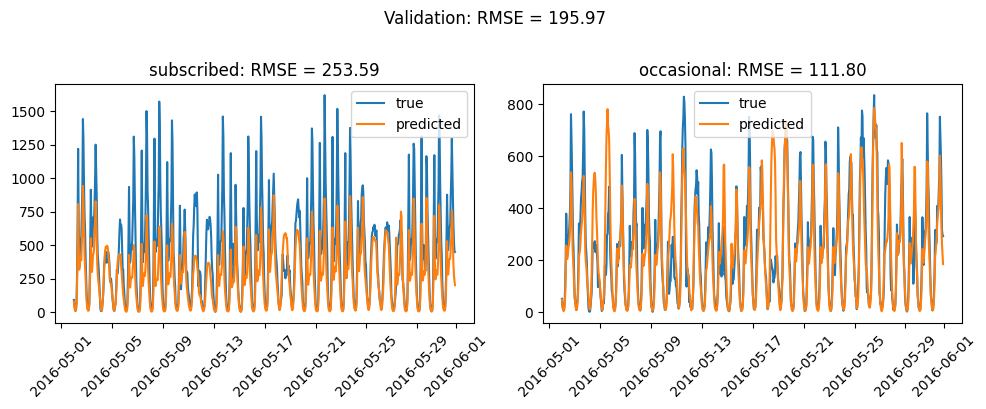

In [46]:
valid_score_s = np.sqrt(mean_squared_error(y_valid_s, y_valid_pred_s))
valid_score_o = np.sqrt(mean_squared_error(y_valid_o, y_valid_pred_o))

y_valid = pd.concat([y_valid_s, y_valid_o])
y_valid_pred = pd.concat([y_valid_pred_s, y_valid_pred_o])
valid_score = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(y_valid_s, label='true')
plt.plot(y_valid_pred_s, label='predicted')
plt.xticks(rotation=45)
plt.legend()
plt.title(f"subscribed: RMSE = {valid_score_s:.2f}")

plt.subplot(1, 2, 2)
plt.plot(y_valid_o, label='true')
plt.plot(y_valid_pred_o, label='predicted')
plt.xticks(rotation=45)
plt.legend()
plt.title(f"occasional: RMSE = {valid_score_o:.2f}")

plt.suptitle(f"Validation: RMSE = {valid_score:.2f}", y=1.01)

plt.tight_layout()

## Test prediction

First of all let's construct the missing features for the test sets except lag features: lag features will be constructed during prediction.

In [47]:
test_df_s['St_Month_Day'] = list(test_df_s[['St_Month', 'St_Day']].itertuples(index=False, name=None))
test_df_o['St_Month_Day'] = list(test_df_o[['St_Month', 'St_Day']].itertuples(index=False, name=None))

for k in ['mean', 'max', 'min', 'std', 'median', 'iqr']:

    test_df_s[f'dayofyear_{k}_te'] = test_df_s['dayofyear'].map(dayofyear_map_dict_s[k])
    test_df_o[f'dayofyear_{k}_te'] = test_df_o['dayofyear'].map(dayofyear_map_dict_o[k])

    test_df_s[f'month_day_{k}_te'] = test_df_s['St_Month_Day'].map(month_day_map_dict_s[k])
    test_df_o[f'month_day_{k}_te'] = test_df_o['St_Month_Day'].map(month_day_map_dict_o[k])

    test_df_s[f'month_{k}_te'] = test_df_s['St_Month'].map(month_map_dict_s[k])
    test_df_o[f'month_{k}_te'] = test_df_o['St_Month'].map(month_map_dict_o[k])

    test_df_s[f'hour_{k}_te'] = test_df_s['St_Hour'].map(hour_map_dict_s[k])
    test_df_o[f'hour_{k}_te'] = test_df_o['St_Hour'].map(hour_map_dict_o[k])

    test_df_s[f'dayofweek_{k}_te'] = test_df_s['dayofweek'].map(dayofweek_map_dict_s[k])
    test_df_o[f'dayofweek_{k}_te'] = test_df_o['dayofweek'].map(dayofweek_map_dict_o[k])

    test_df_s[f'weekofyear_{k}_te'] = test_df_s['weekofyear'].map(weekofyear_map_dict_s[k])
    test_df_o[f'weekofyear_{k}_te'] = test_df_o['weekofyear'].map(weekofyear_map_dict_o[k])

redundant_columns = [
    'St_Hour',  'St_Day', 'St_Month',
    'St_Year', 'User_type','dayofweek', 
    'weekofyear','dayofyear', 'St_Month_Day'
]

test_df_s.drop(columns=redundant_columns, inplace=True)
test_df_s = pd.merge(test_df_s, fs_test_df_s, on='Datetime')
test_df_s = pd.concat([test_df_s, test_df_s_dummies], axis=1)
test_df_s.set_index('Datetime', inplace=True)

test_df_o.drop(columns=redundant_columns, inplace=True)
test_df_o = pd.merge(test_df_o, fs_test_df_o, on='Datetime')
test_df_o = pd.concat([test_df_o, test_df_s_dummies], axis=1)
test_df_o.set_index('Datetime', inplace=True)

Let's make the prediction.

In [48]:
X_test_s = test_df_s.copy()

X_test_s['Rental_Bicycles_Count'] = np.zeros(X_test_s.shape[0])

for i in range(1, N_LAGS+1):
    X_test_s[f'lag{i}_target'] = np.zeros(X_test_s.shape[0])

for j in tqdm(range(X_test_s.shape[0])):
    for i in range(1, N_LAGS+1):
        if i - j > 0:
            X_test_s.loc[X_test_s.index[j], f'lag{i}_target'] = y_valid_s.iloc[-i+j]['Rental_Bicycles_Count']
        else:
            X_test_s.loc[X_test_s.index[j], f'lag{i}_target'] = X_test_s.iloc[j-i]['Rental_Bicycles_Count']

    X_test_s.loc[X_test_s.index[j], 'Rental_Bicycles_Count'] = xgbr_s.predict(
        np.array(list(X_test_s.iloc[j][xgboost_features_s])).reshape(1, -1)
    )[0]

y_test_pred_s = X_test_s[['Rental_Bicycles_Count']]

100%|██████████| 720/720 [00:02<00:00, 251.09it/s]


In [49]:
X_test_o = test_df_o.copy()

X_test_o['Rental_Bicycles_Count'] = np.zeros(X_test_o.shape[0])

for i in range(1, N_LAGS+1):
    X_test_o[f'lag{i}_target'] = np.zeros(X_test_o.shape[0])

for j in tqdm(range(X_test_o.shape[0])):
    for i in range(1, N_LAGS+1):
        if i - j > 0:
            X_test_o.loc[X_test_o.index[j], f'lag{i}_target'] = y_valid_o.iloc[-i+j]['Rental_Bicycles_Count']
        else:
            X_test_o.loc[X_test_o.index[j], f'lag{i}_target'] = X_test_o.iloc[j-i]['Rental_Bicycles_Count']

    X_test_o.loc[X_test_o.index[j], 'Rental_Bicycles_Count'] = xgbr_o.predict(
        np.array(list(X_test_o.iloc[j][xgboost_features_o])).reshape(1, -1)
    )[0]

y_test_pred_o = X_test_o[['Rental_Bicycles_Count']]

100%|██████████| 720/720 [00:03<00:00, 232.32it/s]


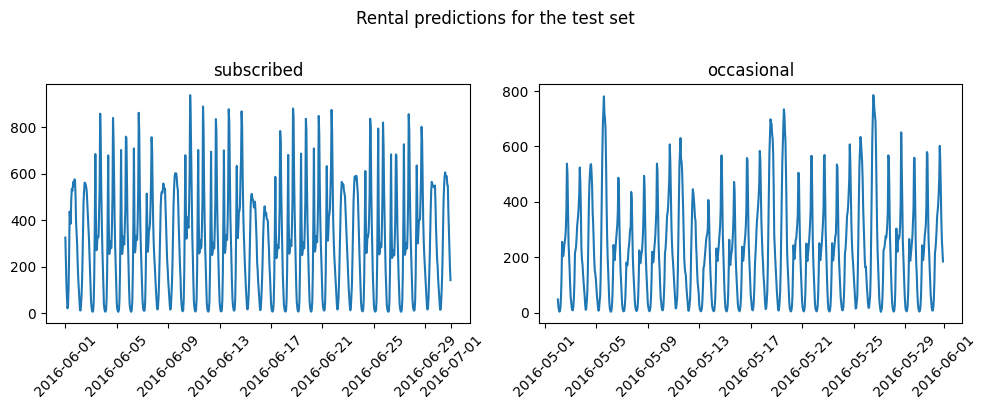

In [50]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(y_test_pred_s)
plt.title("subscribed")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.plot(y_valid_pred_o)
plt.xticks(rotation=45)
plt.title("occasional")

plt.suptitle("Rental predictions for the test set", y=1.01)

plt.tight_layout()

In [51]:
test_pred = pd.concat(
    [
        X_test_s[['index', 'Rental_Bicycles_Count']], 
        X_test_o[['index', 'Rental_Bicycles_Count']]
    ]
).sort_values('index', ascending=True).set_index('index')

sub_df['Rental_Bicycles_Count'] = test_pred['Rental_Bicycles_Count']
sub_df.to_csv('solution3_submit.csv', index=False)
sub_df.head()

,Rental_Bicycles_Count
0,193.780655
1,325.485138
2,149.376770
3,220.427429
4,104.853401


In [52]:
sub_df['Rental_Bicycles_Count'] = test_pred['Rental_Bicycles_Count'].apply(lambda x: round(x))
sub_df.to_csv('rounded_solution3_submit.csv', index=False)
sub_df.head()

,Rental_Bicycles_Count
0,194
1,325
2,149
3,220
4,105
